In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the dataset
df = pd.read_csv('dataset_train.csv')

In [3]:
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_img = Image.open('Homework5_dataset/' + self.data.iloc[idx, 0])
        positive_img = Image.open('Homework5_dataset/' + self.data.iloc[idx, 2])
        negative_img = Image.open('Homework5_dataset/' + self.data.iloc[idx, 1])  # Load negative image

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)  # Transform negative image

        return anchor_img, positive_img, negative_img  # Return all three images


In [5]:
# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming EfficientNet B0 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

# Create a custom dataset
custom_dataset = CustomDataset(df, transform=transform)

In [6]:
# Split dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512, margin_in_loss=1.0):  # Adjust the margin value as needed
        super(APN_Model, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[-1].in_features
        self.efficientnet.classifier[-1] = nn.Linear(in_features, emb_size)
        self.margin_in_loss = margin_in_loss  # Add margin_in_loss as an attribute

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [8]:
# Initialize model and optimizer
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = APN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class FisherTripletLoss(nn.Module):
    def __init__(self, emb_size=512, margin_in_loss=1.0):
        super(FisherTripletLoss, self).__init__()
        self.margin_in_loss = margin_in_loss
        self.epsilon_Sw, self.epsilon_Sb = 0.0001, 0.0001
        self.lambda_ = 0.01

    def forward(self, o1_secondToLast, o2_secondToLast, o3_secondToLast, weights_lastLayer):
        # Calculation of within scatter:
        temp1 = o1_secondToLast - o2_secondToLast
        S_within = torch.matmul(temp1.t(), temp1)

        # Calculation of between scatter:
        temp2 = o1_secondToLast - o3_secondToLast
        S_between = torch.matmul(temp2.t(), temp2)

        # Strengthen main diagonal of S_within and S_between:
        I_matrix = torch.eye(S_within.shape[0], device=o1_secondToLast.device)
        I_matrix_Sw = self.epsilon_Sw * I_matrix
        I_matrix_Sb = self.epsilon_Sb * I_matrix
        S_within = S_within + I_matrix_Sw
        S_between = S_between + I_matrix_Sb

        # Calculation of variance of projection considering within scatter:
        temp3 = torch.matmul(torch.matmul(weights_lastLayer.t(), S_within), weights_lastLayer)
        within_scatter_term = torch.trace(temp3)

        # Calculation of variance of projection considering between scatter:
        temp4 = torch.matmul(torch.matmul(weights_lastLayer.t(), S_between), weights_lastLayer)
        between_scatter_term = torch.trace(temp4)

        # Calculation of loss:
        loss_ = self.margin_in_loss + ((2 - self.lambda_) * within_scatter_term) - (self.lambda_ * between_scatter_term)
        loss = torch.max(torch.tensor(0.0).to(o1_secondToLast.device), loss_)
        return loss

In [10]:
triplet_loss = FisherTripletLoss()

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Training loop
num_epochs = 20
best_val_loss = float('inf')
early_stopping_patience = 5
no_improvement_count = 0

# Lists to store the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
  
    for batch in progress_bar:
        anchor_images, positive_images, negative_images = batch
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        negative_embeddings = model(negative_images)

        # Convert embeddings to the same device as the model's weight
        anchor_embeddings = anchor_embeddings.to(device)
        positive_embeddings = positive_embeddings.to(device)
        negative_embeddings = negative_embeddings.to(device)

        # Compute Fisher triplet loss
        loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings, model.efficientnet.classifier[-1].weight)


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'Train Loss': total_loss / len(progress_bar)})
    
    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in progress_bar:
            anchor_images, positive_images, negative_images = batch
            anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

            # Forward pass
            anchor_embeddings = model(anchor_images)
            positive_embeddings = model(positive_images)
            negative_embeddings = model(negative_images)

            # Convert embeddings to the same device as the model's weight
            anchor_embeddings = anchor_embeddings.to(device)
            positive_embeddings = positive_embeddings.to(device)
            negative_embeddings = negative_embeddings.to(device)

            # Compute Fisher triplet loss
            loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings, model.efficientnet.classifier[-1].weight)

            
            val_loss += loss.item()
    
    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Save the trained model
torch.save(model.state_dict(), 'model_loss_FDA_triplet.pth')

Epoch [1/20] | Train Loss: 50.9503 | Val Loss: 5.3035


Epoch [2/20] | Train Loss: 1.8180 | Val Loss: 4.5632


Epoch [3/20] | Train Loss: 1.3197 | Val Loss: 4.3424


Epoch [4/20] | Train Loss: 1.1849 | Val Loss: 4.2476


Epoch [5/20] | Train Loss: 1.1342 | Val Loss: 4.1979


Epoch [6/20] | Train Loss: 1.1024 | Val Loss: 4.1679


Epoch [7/20] | Train Loss: 1.0822 | Val Loss: 4.1482


Epoch [8/20] | Train Loss: 1.0735 | Val Loss: 4.1350


Epoch [9/20] | Train Loss: 1.0620 | Val Loss: 4.1247


Epoch [10/20] | Train Loss: 1.0551 | Val Loss: 4.1172


Epoch [11/20] | Train Loss: 1.0499 | Val Loss: 4.1115


Epoch [12/20] | Train Loss: 1.0464 | Val Loss: 4.1067


Epoch [13/20] | Train Loss: 1.0436 | Val Loss: 4.1029


Epoch [14/20] | Train Loss: 1.0395 | Val Loss: 4.0999


Epoch [15/20] | Train Loss: 1.0384 | Val Loss: 4.0974


Epoch [16/20] | Train Loss: 1.0357 | Val Loss: 4.0950


Epoch [17/20] | Train Loss: 1.0343 | Val Loss: 4.0931


Epoch [18/20] | Train Loss: 1.0327 | Val Loss: 4.0914


Epoch [19/20] | Train Loss: 1.0317 | Val Loss: 4.0899


Epoch [20/20] | Train Loss: 1.0304 | Val Loss: 4.0884


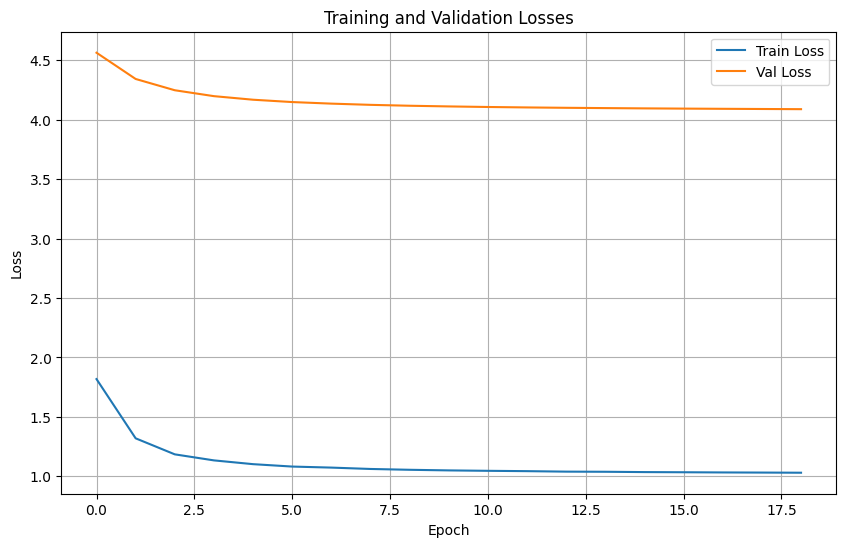

In [12]:
# Plot training and validation losses (excluding the first value)
plt.figure(figsize=(10, 6))
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Losses')
plt.show()

In [13]:
# Load the model
model_path = 'model_loss_FDA_triplet.pth'
model = APN_Model().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("train model loaded")

train model loaded


In [14]:
# Function to calculate similarity scores
def calculate_similarity(embedding1, embedding2):
    # Cosine similarity is a common choice
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()


# Prepare data for ROC
similarity_scores = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        anchor_images, positive_images, negative_images = batch  
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass for anchor-positive pairs
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        scores_positive = calculate_similarity(anchor_embeddings, positive_embeddings)
        similarity_scores.extend(scores_positive)
        true_labels.extend([1] * len(scores_positive))  # 1 for similar

        # Forward pass for anchor-negative pairs
        negative_embeddings = model(negative_images)
        scores_negative = calculate_similarity(anchor_embeddings, negative_embeddings)
        similarity_scores.extend(scores_negative)
        true_labels.extend([0] * len(scores_negative))  # 0 for not similar

In [15]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

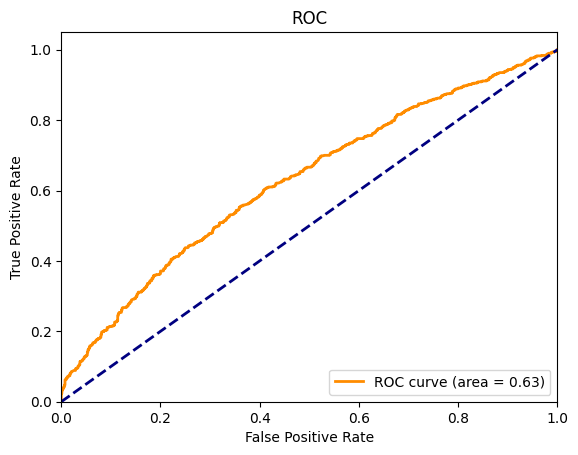

In [16]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

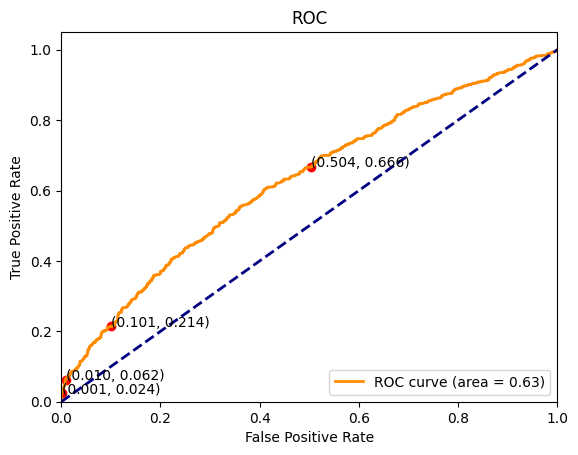

In [17]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

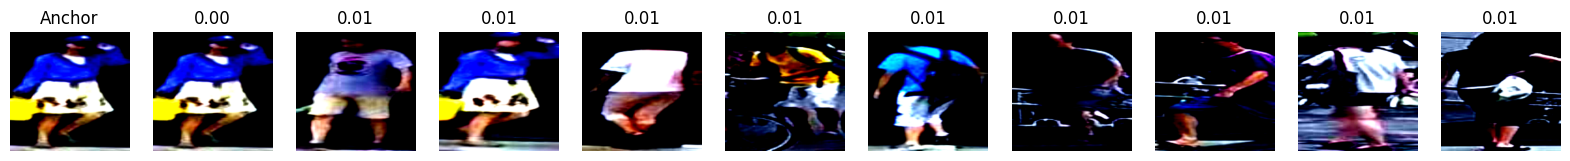

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

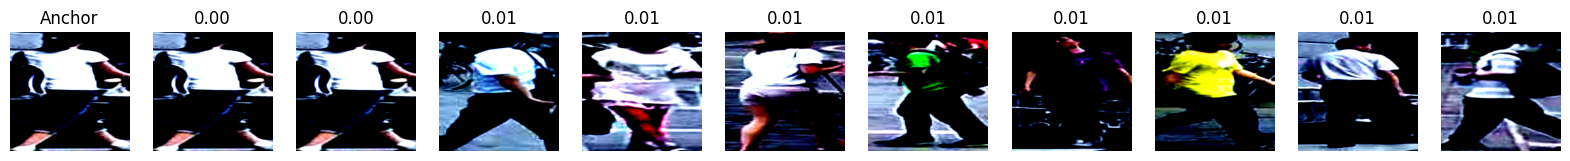

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

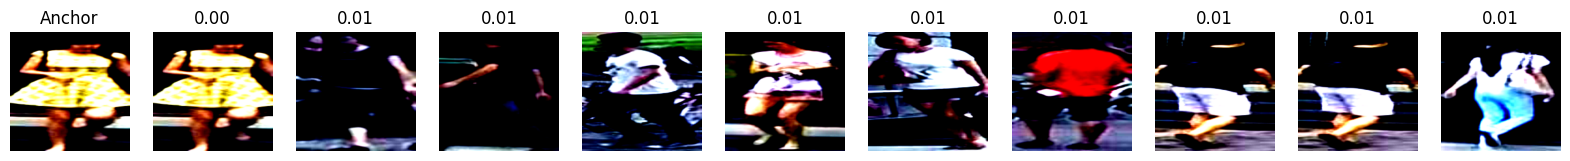

In [18]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

def calculate_distance(embedding1, embedding2):
    embedding1 = embedding1.to('cpu')
    embedding2 = embedding2.to('cpu')
    return torch.norm(embedding1 - embedding2, dim=1).numpy()


# Select 3 random anchors from the validation set
random_indices = random.sample(range(len(val_dataset)), 3)
random_anchors = [val_dataset[i][0] for i in random_indices]  
# Compute embeddings for the entire validation set
all_embeddings = []
with torch.no_grad():
    for batch in val_loader:
        images, _, _ = batch  # Assuming order is anchor, positive, negative
        images = images.to(device)
        embeddings = model(images)
        all_embeddings.extend(embeddings.cpu())

# Plotting function
def plot_images_with_scores(anchor, top_indices, scores):
    fig, axs = plt.subplots(1, 11, figsize=(20, 5))
    axs[0].imshow(anchor.permute(1, 2, 0))
    axs[0].set_title("Anchor")
    axs[0].axis('off')

    for i in range(10):
        image, _, _ = val_dataset[top_indices[i]]
        axs[i + 1].imshow(image.permute(1, 2, 0))
        axs[i + 1].set_title(f"{scores[i]:.2f}")
        axs[i + 1].axis('off')

    plt.show()

# Find and plot top 10 nearest for each anchor
for anchor in random_anchors:
    anchor_embedding = model(anchor.unsqueeze(0).to(device))
    distances = []
    with torch.no_grad():
        for emb in all_embeddings:
            distance = calculate_distance(anchor_embedding, emb.unsqueeze(0))
            distances.append(distance[0])

    # Get indices of top 10 nearest images
    top_indices = np.argsort(distances)[:10]
    top_scores = np.sort(distances)[:10]

    # Plot
    plot_images_with_scores(anchor.cpu(), top_indices, top_scores)
